# Simple Layer

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y

        return out
    
    def backward(self, dout):
        dx = dout * self.y  # x와 y를 바꾼다.
        dy = dout * self.x

        return dx, dy

In [2]:
apple = 100
apple_num = 2
tax = 1.1

# layers
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [4]:
# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


In [5]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [6]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layers
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
mul_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = mul_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = mul_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)
print(dapple_num, dapple, dorange, dorange_num, dtax)

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


# Activate Function Layer

In [38]:
from data.functions import *

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx
    

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out

        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:  # 정답 레이블이 원-핫 인코딩일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        return dx

# Affine Layer

In [12]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

# Neural Network

In [19]:
from collections import OrderedDict
from data.layers import *
from data.gradient import numerical_gradient
from data.functions import *

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):

        # weight 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # layer 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:  # 정답 레이블이 원-핫 인코딩일시
            t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W : self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):

        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # result save
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

In [ ]:
from data.mnist import load_mnist
import numpy as np

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
    
train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train) 
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.11705 0.126
0.5835 0.5889
0.77425 0.782
0.8433 0.8482
0.8696 0.8742
0.8826666666666667 0.8864
0.8909166666666667 0.893
0.8968 0.8989
0.9013 0.9021
0.9042333333333333 0.9063
0.907 0.9087
0.9092166666666667 0.9124
0.9116 0.9142
0.91365 0.9175
0.9155333333333333 0.9187
0.9168666666666667 0.9199
0.9190166666666667 0.9202


# Gradient Check

In [23]:
from data.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ':' + str(diff))

W1:3.98491226933777e-10
b1:2.21131190190259e-09
W2:5.0083029101545096e-09
b2:1.4055765520937236e-07


# Probability Distribution

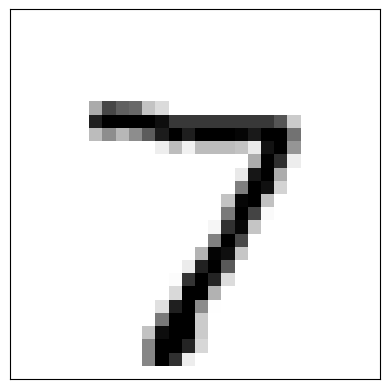

[[0.099702   0.10011807 0.09959121 0.10026928 0.1000813  0.10007364
  0.10069577 0.09908766 0.09922925 0.10115182]]
[[0.1093893  0.08888504 0.09158293 0.10784292 0.0977331  0.10058299
  0.09679854 0.10421263 0.09854849 0.10442407]]
[[0.01875556 0.01948155 0.01634175 0.04708465 0.12300107 0.05917601
  0.01008718 0.37396973 0.06321103 0.26889147]]
[[2.27785727e-03 1.02003477e-03 1.37206169e-03 8.95432024e-03
  2.06780095e-02 9.92133294e-03 1.98455025e-04 8.02043081e-01
  1.45224892e-02 1.39012359e-01]]
[[5.08347181e-04 9.42212089e-05 3.71674720e-04 2.23873600e-03
  1.24588891e-03 1.55120189e-03 8.85956486e-06 9.41498430e-01
  2.07229474e-03 5.04103463e-02]]
[[4.75053907e-04 4.06996667e-05 2.69014621e-04 1.91412621e-03
  2.75273441e-04 4.98435563e-04 1.80622957e-06 9.70242989e-01
  8.67029612e-04 2.54155720e-02]]
[[3.84750191e-04 1.19505993e-05 2.00482205e-04 1.49436959e-03
  6.39654723e-05 1.97269559e-04 5.69183242e-07 9.78768906e-01
  3.21701962e-04 1.85560354e-02]]
[[1.63890701e-04 3.5

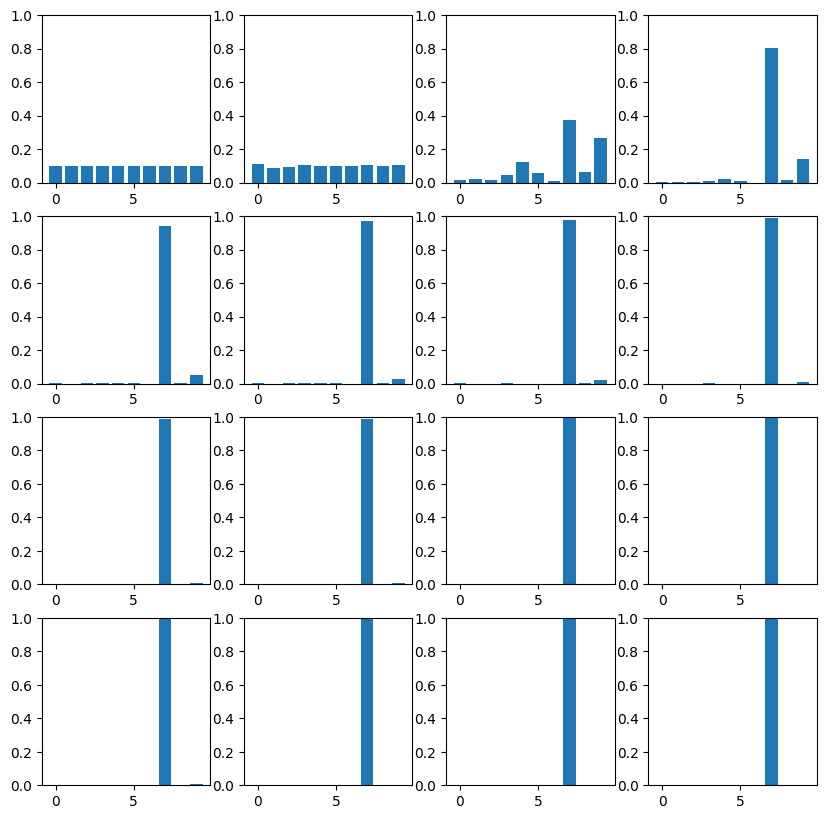

In [41]:
from data.mnist import load_mnist
import matplotlib.pyplot as plt
from data.functions import *


(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

sample = x_test[0]

plt.figure()
plt.imshow(sample.reshape(28, 28), cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.show()

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 1000
eval_interval = 50
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

iter_per_epoch = max(train_size / batch_size, 1)

plt.figure(figsize=(10, 10))
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    if (i % eval_interval == 0) & ((i//eval_interval) < 16):
        probability = softmax(network.predict(sample.reshape(1, 784)))
        print(probability)
        plt.subplot(4, 4, int((i//eval_interval) + 1))
        plt.bar(range(len(probability[0])), probability[0])
        plt.ylim(0, 1.0)
plt.show()

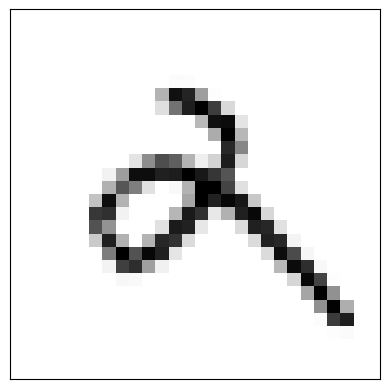

[[0.10073697 0.10128102 0.09942889 0.10123373 0.09998665 0.09968899
  0.09888658 0.0987436  0.10030388 0.09970969]]
[[0.095078   0.11076401 0.11204256 0.11065873 0.09570218 0.09279645
  0.10071447 0.09267898 0.09946608 0.09009853]]
[[0.03366365 0.15341056 0.12678306 0.10252067 0.09767936 0.08782944
  0.12581848 0.04753956 0.14019619 0.08455903]]
[[0.00912869 0.14260505 0.08886151 0.06750971 0.13411987 0.08545175
  0.12365074 0.02367549 0.19293662 0.13206057]]
[[0.00398116 0.14536902 0.08010678 0.05354714 0.20766835 0.06781864
  0.11552813 0.01888054 0.17918056 0.12791968]]
[[0.00244847 0.10557097 0.03697153 0.04652521 0.28949837 0.07777752
  0.08080237 0.00972063 0.17977938 0.17090557]]
[[0.00167324 0.10278997 0.05864129 0.04513568 0.25684286 0.05073888
  0.07789791 0.01219029 0.20124499 0.1928449 ]]
[[0.00113869 0.08283854 0.05503626 0.05082315 0.27861824 0.03766279
  0.08045814 0.00757936 0.21593724 0.18990759]]
[[0.00133173 0.08161324 0.04530923 0.03212935 0.25955123 0.03182339
  0.

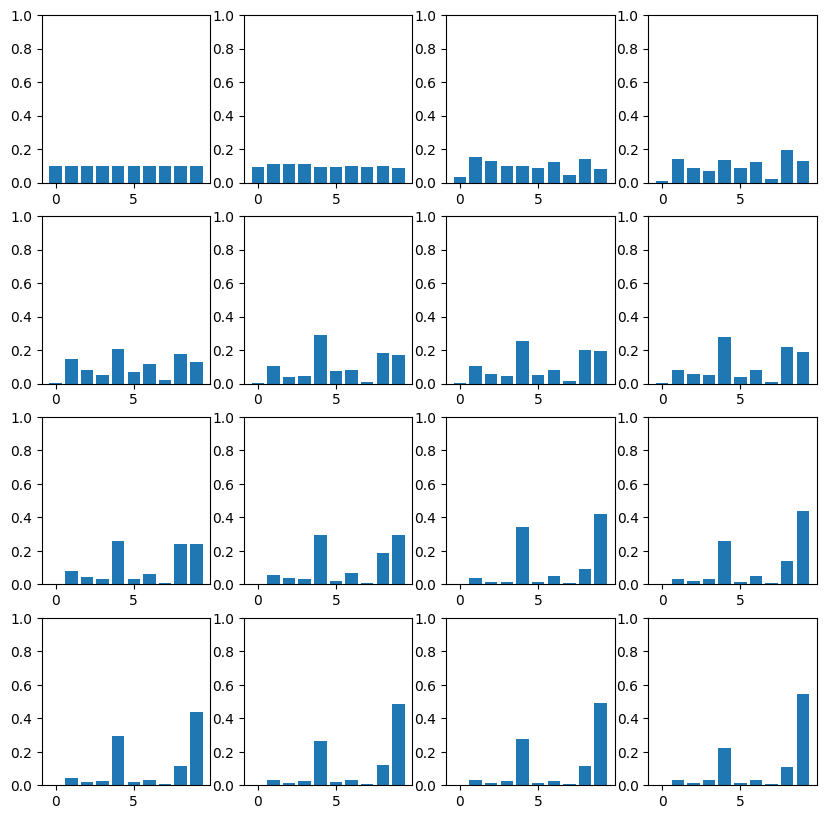

In [42]:
from data.mnist import load_mnist
import matplotlib.pyplot as plt
from data.functions import *


(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

sample = x_test[149]

plt.figure()
plt.imshow(sample.reshape(28, 28), cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.show()

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 1000
eval_interval = 50
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

iter_per_epoch = max(train_size / batch_size, 1)

plt.figure(figsize=(10, 10))
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    if (i % eval_interval == 0) & ((i//eval_interval) < 16):
        probability = softmax(network.predict(sample.reshape(1, 784)))
        print(probability)
        plt.subplot(4, 4, int((i//eval_interval) + 1))
        plt.bar(range(len(probability[0])), probability[0])
        plt.ylim(0, 1.0)
plt.show()